In [1]:
! pip uninstall torch --y
! pip uninstall torchaudio torchvision --y
! pip install torch==2.4
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
! pip install torch-geometric
! pip install scikit-learn
! pip install matplotlib

import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/torch/_compile.py:31: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Epoch 01, Loss: 1.3852, Val AP: 0.5458, Val AUC: 0.5438, Test AUC: 0.5436
Epoch 1 completed in 121.44s
Epoch 02, Loss: 1.2914, Val AP: 0.6678, Val AUC: 0.7134, Test AUC: 0.7196
Epoch 2 completed in 113.49s
Epoch 03, Loss: 1.2011, Val AP: 0.7386, Val AUC: 0.7822, Test AUC: 0.7875
Epoch 3 completed in 116.13s
Epoch 04, Loss: 1.1132, Val AP: 0.7809, Val AUC: 0.8171, Test AUC: 0.8017
Epoch 4 completed in 114.84s
Epoch 05, Loss: 1.0544, Val AP: 0.8069, Val AUC: 0.8363, Test AUC: 0.8184
Epoch 5 completed in 118.57s
Epoch 06, Loss: 1.0011, Val AP: 0.8212, Val AUC: 0.8479, Test AUC: 0.8337
Epoch 6 completed in 124.82s
Epoch 07, Loss: 0.9841, Val AP: 0.8161, Val AUC: 0.8462, Test AUC: 0.8384
Epoch 7 completed in 124.75s
Epoch 08, Loss: 0.9371, Val AP: 0.8357, Val AUC: 0.8616, Test AUC: 0.8555
Epoch 8 completed in 120.63s
Epoch 09, Loss: 0.9253, Val AP: 0.8466, Val AUC: 0.8696, Test AUC: 0.8628
Epoch 9 completed in 122.16s
Epoch 10, Loss: 0.9062, Val AP: 0.8491, Val AUC: 0.8742, Test AUC: 0.8646

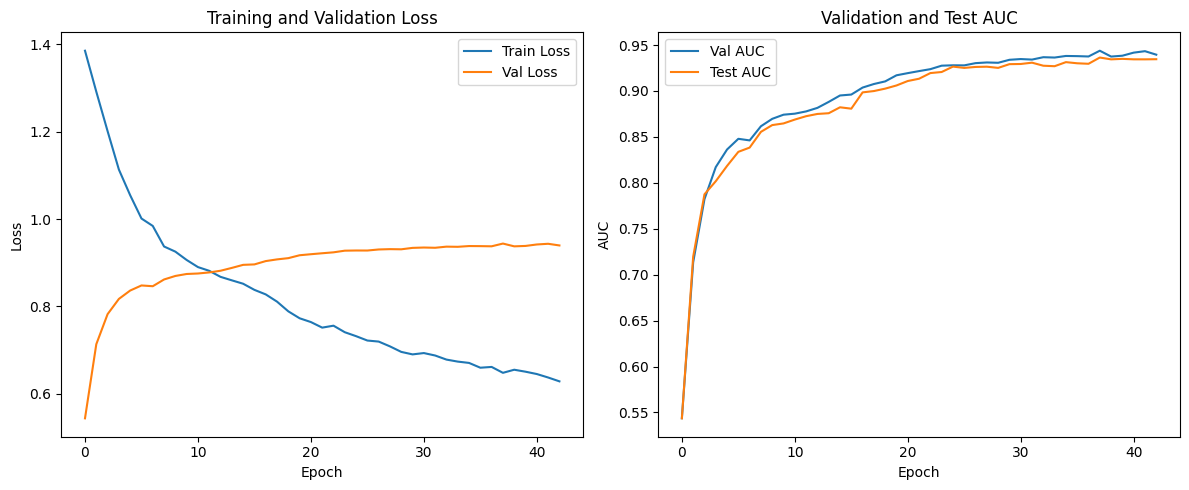

In [3]:
import os.path as osp
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import torch.nn.functional as F
import torch
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv, GCNConv, SAGPooling
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator, LastNeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path and dataset setup
path = osp.join('/content/', 'data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0].to(device)

# Split dataset into train/val/test
train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.15, test_ratio=0.15)

# Initialize data loaders
train_loader = TemporalDataLoader(train_data, batch_size=512, neg_sampling_ratio=1.0)
val_loader = TemporalDataLoader(val_data, batch_size=512, neg_sampling_ratio=1.0)
test_loader = TemporalDataLoader(test_data, batch_size=512, neg_sampling_ratio=1.0)

# Initialize neighbor loader
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)


# Utility function for optional debugging output
def debug_shapes(**shapes):
    for name, value in shapes.items():
        print(f"{name} shape: {value.shape}")


class DoubleMemPoolLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_nodes, memory_dim, ratio=0.25, use_attention=False):
        super().__init__()
        self.num_clusters = max(1, int(ratio * num_nodes))
        self.memory_dim = memory_dim
        self.use_attention = use_attention

        # Initial embedding GNN
        self.gnn_embed = GCNConv(in_channels, hidden_channels)

        # First pooling layer
        self.pool1 = SAGPooling(hidden_channels, ratio=ratio)

        # Second pooling layer (optional for ablation)
        self.pool2 = SAGPooling(hidden_channels, ratio=ratio)

        # Attention (optional)
        if self.use_attention:
            self.attention = torch.nn.MultiheadAttention(embed_dim=hidden_channels, num_heads=4, batch_first=True)

    def forward(self, x, edge_index, batch, debug=False):
        # Generate initial node embeddings
        x = self.gnn_embed(x, edge_index)

        # Optional attention on initial embeddings
        if self.use_attention:
            x = x.unsqueeze(0)  # Add batch dimension for attention
            x, _ = self.attention(x, x, x)
            x = x.squeeze(0)

        # First pooling layer
        x, edge_index, _, batch, perm, score1 = self.pool1(x, edge_index, batch=batch)

        # Second pooling layer
        x, edge_index, _, batch, perm, score2 = self.pool2(x, edge_index, batch=batch)

        if debug:
            print(f"x shape after second pooling: {x.shape}")
            print(f"edge_index shape after second pooling: {edge_index.shape}")

        return x, edge_index, (score1, score2)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2, dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class FeatureFusion(torch.nn.Module):
    def __init__(self, tgn_dim, diffpool_dim, output_dim):
        super().__init__()
        self.tgn_projection = Linear(tgn_dim, output_dim)
        self.diffpool_projection = Linear(diffpool_dim, output_dim)
        self.attention = torch.nn.MultiheadAttention(embed_dim=output_dim, num_heads=4, batch_first=True)
        self.final_projection = Linear(output_dim, output_dim)

    def forward(self, tgn_features, diffpool_features):
        tgn_proj = self.tgn_projection(tgn_features)
        diffpool_proj = self.diffpool_projection(diffpool_features)
        diffpool_proj = F.interpolate(diffpool_proj.unsqueeze(0).unsqueeze(0),
                                      size=(tgn_proj.size(0), diffpool_proj.size(1)),
                                      mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        combined = tgn_proj + diffpool_proj
        attended, _ = self.attention(combined.unsqueeze(0), combined.unsqueeze(0), combined.unsqueeze(0))
        return self.final_projection(attended.squeeze(0))


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = (self.lin_src(z_src) * self.lin_dst(z_dst)).relu()
        return self.lin_final(h)


# Model dimensions
memory_dim = time_dim = embedding_dim = 100
hidden_dim = 64
final_dim = 128

# Initialize models
memory = TGNMemory(data.num_nodes, data.msg.size(-1), memory_dim, time_dim,
                   message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
                   aggregator_module=LastAggregator()).to(device)
gnn = GraphAttentionEmbedding(memory_dim, embedding_dim, data.msg.size(-1), memory.time_enc).to(device)
double_mem_pool = DoubleMemPoolLayer(memory_dim, hidden_dim, data.num_nodes, memory_dim, use_attention=False).to(device)
fusion = FeatureFusion(embedding_dim, hidden_dim, final_dim).to(device)
link_pred = LinkPredictor(final_dim).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(list(memory.parameters()) + list(gnn.parameters()) + list(double_mem_pool.parameters()) +
                             list(fusion.parameters()) + list(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector for node mapping
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def process_batch(batch, debug=False):
    n_id, edge_index, e_id = neighbor_loader(batch.n_id)
    assoc[n_id] = torch.arange(n_id.size(0), device=device)
    batch_vector = torch.zeros(n_id.size(0), dtype=torch.long, device=device)

    # TGN embedding
    z, last_update = memory(n_id)
    z_tgn = gnn(z, last_update, edge_index, data.t[e_id].to(device), data.msg[e_id].to(device))

    # Double MemPool embedding with optional attention
    z_diffpool, adj_diffpool, (score1, score2) = double_mem_pool(z, edge_index, batch_vector, debug=debug)

    # Fuse features
    z_combined = fusion(z_tgn, z_diffpool)
    return z_combined, score1, score2


# Training and evaluation functions
def train_epoch():
    memory.train(), gnn.train(), double_mem_pool.train(), fusion.train(), link_pred.train()
    memory.reset_state(), neighbor_loader.reset_state()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Process batch and get combined embeddings
        z_combined, score1, score2 = process_batch(batch, debug=False)

        # Link prediction
        pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
        neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

        # Binary cross-entropy loss
        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        # Backpropagation
        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def evaluate(loader):
    memory.eval(), gnn.eval(), double_mem_pool.eval(), fusion.eval(), link_pred.eval()
    torch.manual_seed(12345)

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)
        z_combined, score1, score2 = process_batch(batch)
        pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
        neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())


# Training loop with early stopping
import time
import matplotlib.pyplot as plt

train_losses, val_losses, val_aucs, test_aucs = [], [], [], []
best_val_auc = 0
early_stopping_patience = 5
patience_counter = 0

for epoch in range(1, 151):
    start_time = time.time()
    train_loss = train_epoch()
    val_ap, val_auc = evaluate(val_loader)
    test_ap, test_auc = evaluate(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_auc)
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)

    print(f'Epoch {epoch:02d}, Loss: {train_loss:.4f}, Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        if epoch % 10 == 0:
            torch.save({
                'memory': memory.state_dict(),
                'gnn': gnn.state_dict(),
                'double_mem_pool': double_mem_pool.state_dict(),
                'fusion': fusion.state_dict(),
                'link_pred': link_pred.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'val_auc': val_auc,
            }, f"model_checkpoint_epoch_{epoch}.pth")

    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f}s")

# Plotting Loss and AUC over Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Val AUC')
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation and Test AUC')
plt.tight_layout()
plt.show()
